# 0. Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm

from os import cpu_count

# custom modules
from code.util import *
from code.preprocessor import *
from code.modelhelper import *

# set number of processes
N_JOBS = cpu_count() // 4
# N_JOBS = 1

---

In [2]:
data = load("data/urls_sampled.pkl")

# 1. Train/Test Split

In [3]:
x, y = data.url, data.target
x_train0, x_test0, y_train, y_test = train_test_split(x, y, 
                                                test_size=0.33, random_state=42)

# 2. Vectorization

In [4]:
vect = TfidfVectorizer(
    tokenizer=tokenize,
    max_features=4000
)

In [5]:
vect.fit(x_train0)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=4000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x13335ad40>, use_idf=True,
                vocabulary=None)

In [6]:
x_train = vect.transform(x_train0).toarray()
x_test = vect.transform(x_test0).toarray()

# 3. Models

In [7]:
scores_dict = {}
scoring = ["accuracy", "recall"]

## 3.1 Multinomial Naive Bayes

In [8]:
multnb = MultinomialNB(
    alpha=0.09
)

In [9]:
cv_scores = workflow(multnb, "MultinomialNB", scoring, 5,
                     x_train, x_test, y_train, y_test, N_JOBS)

MultinomialNB(alpha=0.09, class_prior=None, fit_prior=True)

MODEL: MultinomialNB
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     34753
           1       0.95      0.86      0.90      7251

    accuracy                           0.97     42004
   macro avg       0.96      0.93      0.94     42004
weighted avg       0.97      0.97      0.97     42004

Cross validation score: 17.2909 (+/- 8.6698) [fit_time / MultinomialNB]
Cross validation score: 0.5394 (+/- 0.1102) [score_time / MultinomialNB]
Cross validation score: 0.9679 (+/- 0.0004) [test_accuracy / MultinomialNB]
Cross validation score: 0.8641 (+/- 0.0016) [test_recall / MultinomialNB]

Elapsed time: 37.05s [fit 1.17s, predict 0.62s, cv: 35.26s]


In [10]:
scores_dict["MultinomialNB"] = cv_scores

In [11]:
save(multnb, "models/multnb.pkl")

## 3.2 Decision Tree

In [12]:
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    random_state=42
)

In [13]:
cv_scores = workflow(tree, "DecisionTreeClassifier", scoring, 5,
                     x_train, x_test, y_train, y_test, N_JOBS)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

MODEL: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     34753
           1       0.97      0.63      0.76      7251

    accuracy                           0.93     42004
   macro avg       0.95      0.81      0.86     42004
weighted avg       0.93      0.93      0.93     42004

Cross validation score: 77.8934 (+/- 14.2269) [fit_time / DecisionTreeClassifier]
Cross validation score: 0.7603 (+/- 0.2562) [score_time / DecisionTreeClassifier]
Cross validation score: 0.9288 (+/- 0.0011) [test_accuracy / DecisionTreeClass

In [14]:
scores_dict["DecisionTreeClassifier"] = cv_scores

In [15]:
save(tree, "models/tree.pkl")

## 3.3 Random Forest

In [16]:
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=N_JOBS
)

In [17]:
cv_scores = workflow(forest, "RandomForestClassifier", scoring, 5,
                     x_train, x_test, y_train, y_test, N_JOBS)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

MODEL: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     34753
           1       1.00      0.29      0.45      7251

    accuracy                           0.88     42004
   macro avg       0.94      0.65      0.69     42004
weighted avg       0.89      0.88      0.85     42004

Cross validation score: 69.5092 (+/- 21.4496) [fit_time / RandomForestClassifier]
Cross validation score: 1.4113 (+/- 0.6916) [score_time / RandomForestClassi

In [18]:
scores_dict["RandomForestClassifier"] = cv_scores

In [19]:
save(forest, "models/forest.pkl")

## 3.4 Gradient Boosting (w/ LightGBM)

In [20]:
lgbm = lightgbm.LGBMClassifier(
    num_leaves=127,
    n_estimators=1000,
    max_depth=-1,
    objective="binary",
    n_jobs=3,
    random_state=42
)

In [21]:
cv_scores = workflow(lgbm, "LGBMClassifier", scoring, 5,
                     x_train, x_test, y_train, y_test, 4)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=3, num_leaves=127, objective='binary',
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

MODEL: LGBMClassifier
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34753
           1       0.95      0.89      0.92      7251

    accuracy                           0.97     42004
   macro avg       0.96      0.94      0.95     42004
weighted avg       0.97      0.97      0.97     42004

Cross validation score: 128.4228 (+/- 40.6396) [fit_time / LGBMClassifier]
Cross validation score: 15.6214 (+/- 3.4157) [score_time / LGBMClassifier]
Cross validation score: 0.9713 (+/- 0.

In [22]:
scores_dict["LGBMClassifier"] = cv_scores

In [23]:
save(lgbm, "models/lgbm.pkl")

## 3.5 Logistic Regression

In [24]:
logireg = LogisticRegression(
    n_jobs=N_JOBS
)

In [25]:
cv_scores = workflow(logireg, "LogisticRegression", scoring, 5,
                     x_train, x_test, y_train, y_test, N_JOBS)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=3, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

MODEL: LogisticRegression
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34753
           1       0.97      0.87      0.92      7251

    accuracy                           0.97     42004
   macro avg       0.97      0.93      0.95     42004
weighted avg       0.97      0.97      0.97     42004

Cross validation score: 15.6603 (+/- 6.8499) [fit_time / LogisticRegression]
Cross validation score: 0.2700 (+/- 0.0410) [score_time / LogisticRegression]
Cross validation score: 0.9722 (+/- 0.0010) [test_accuracy / LogisticRegression]
Cross validation score: 0.8638 (+/- 0.0060) [test_recall / LogisticRegression]

Elapsed 

In [26]:
scores_dict["LogisticRegression"] = cv_scores

In [27]:
save(logireg, "models/logireg.pkl")

## 3.6 Voting Classifier
Ensemble of the three best performing models

In [28]:
model1 = MultinomialNB(
    alpha=0.09
)

model2 = lightgbm.LGBMClassifier(
    num_leaves=127,
    n_estimators=1000,
    max_depth=-1,
    objective="binary",
    n_jobs=2,
    random_state=42
)

model3 = LogisticRegression(n_jobs=N_JOBS)

voting = VotingClassifier(
    estimators=[
        ("mnb", model1),
        ("lgbm", model2),
        ("logi", model3)
    ],
    voting="soft",
    n_jobs=3
)

In [29]:
cv_scores = workflow(voting, "VotingClassifier", scoring, 2,
                     x_train, x_test, y_train, y_test, N_JOBS)

VotingClassifier(estimators=[('mnb',
                              MultinomialNB(alpha=0.09, class_prior=None,
                                            fit_prior=True)),
                             ('lgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=1000, n_jobs=2,
                                             num_leaves=127, objective='b...
                                             subsample=1.0,
                               

In [30]:
scores_dict["VotingClassifier"] = cv_scores

In [31]:
save(voting, "models/voting.pkl")

In [32]:
save(scores_dict, "data/cv_scores.pkl")

# 4. Performance Evaluation

In [33]:
scores_dict = load("data/cv_scores.pkl")

In [34]:
models = {
    "MultinomialNB": multnb,
    "DecisionTreeClassifier": tree,
    "RandomForestClassifier": forest,
    "LGBMClassifier": lgbm,
    "LogisticRegression": logireg,
    "VotingClassifier": voting
}

## 4.1 Average Cross Validation Accuracy

In [35]:
print("--- Mean Accuracy ---")
for name, score in scores_dict.items():
    print("{}: ".format(name) + "%0.4f"%(score["test_accuracy"].mean()))

--- Mean Accuracy ---
MultinomialNB: 0.9679
DecisionTreeClassifier: 0.9288
RandomForestClassifier: 0.8737
LGBMClassifier: 0.9713
LogisticRegression: 0.9722
VotingClassifier: 0.9740


In [36]:
print("--- Mean Recall ---")
for name, score in scores_dict.items():
    print("{}: ".format(name) + "%0.4f"%(score["test_recall"].mean()))

--- Mean Recall ---
MultinomialNB: 0.8641
DecisionTreeClassifier: 0.6202
RandomForestClassifier: 0.2903
LGBMClassifier: 0.8863
LogisticRegression: 0.8638
VotingClassifier: 0.8766


In [37]:
# boxplot data

acc_data = [
    scores_dict["RandomForestClassifier"]["test_accuracy"],
    scores_dict["DecisionTreeClassifier"]["test_accuracy"],
    scores_dict["LGBMClassifier"]["test_accuracy"],
    scores_dict["MultinomialNB"]["test_accuracy"],
    scores_dict["LogisticRegression"]["test_accuracy"],
    scores_dict["VotingClassifier"]["test_accuracy"],
]

rec_data = [
    scores_dict["RandomForestClassifier"]["test_recall"],
    scores_dict["DecisionTreeClassifier"]["test_recall"],
    scores_dict["LGBMClassifier"]["test_recall"],
    scores_dict["MultinomialNB"]["test_recall"],
    scores_dict["LogisticRegression"]["test_recall"],
    scores_dict["VotingClassifier"]["test_recall"],
]

labels = [
    "RandomForestClassifier",
    "DecisionTreeClassifier",
    "LGBMClassifier",
    "MultinomialNB",
    "LogisticRegression",
    "VotingClassifier",
]

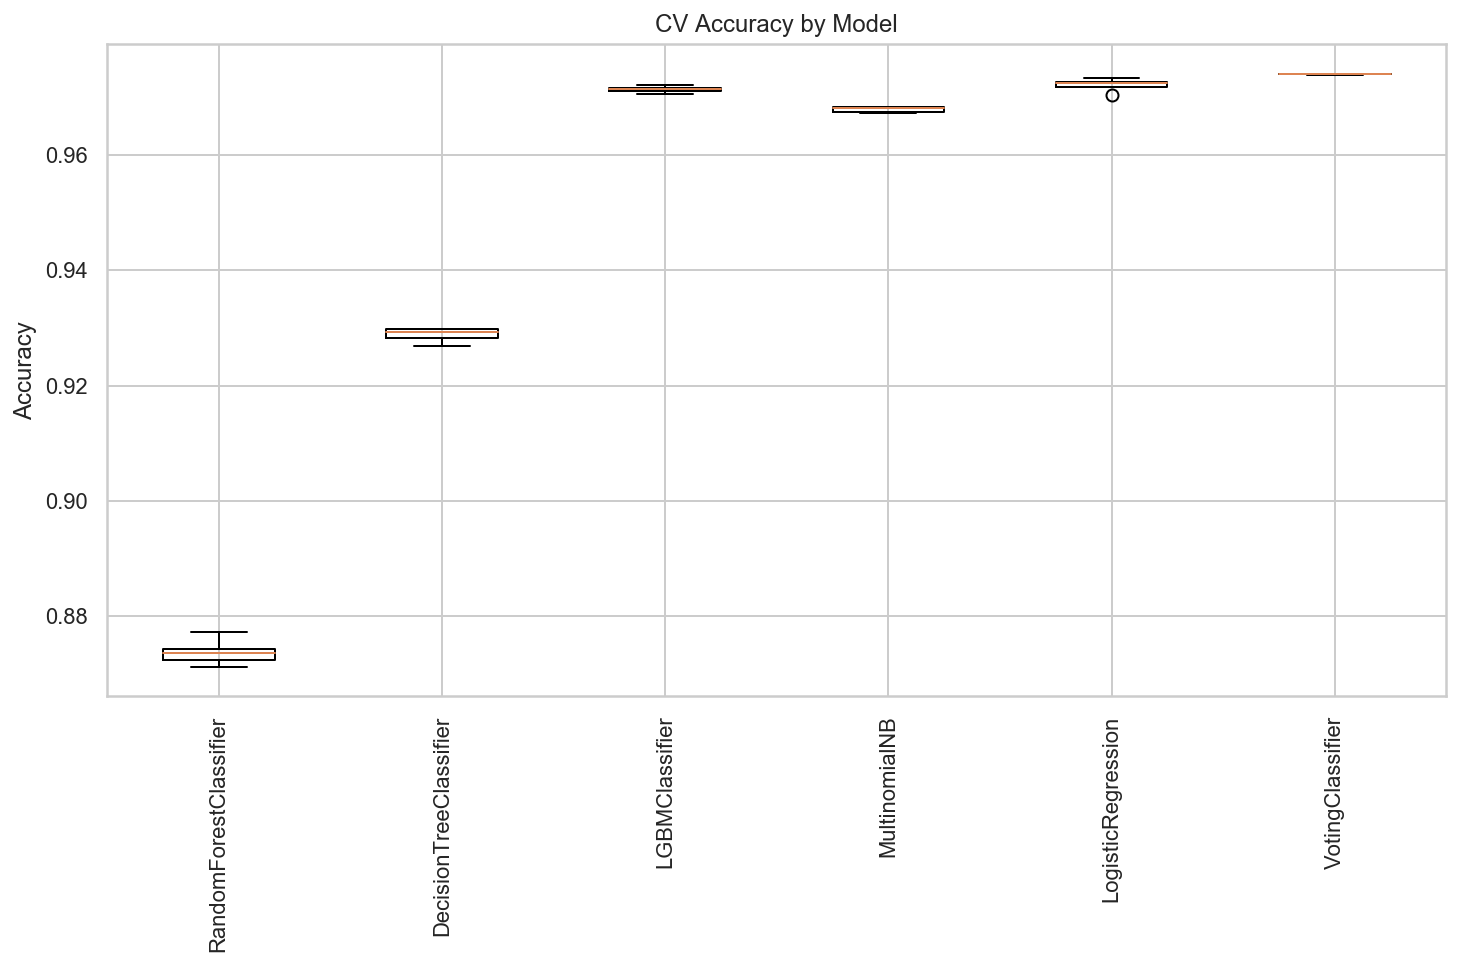

In [38]:
plt.figure(figsize=(12, 6))
plt.boxplot(acc_data)
plt.xticks(ticks=range(1, 7), labels=labels, rotation=90)
plt.title("CV Accuracy by Model")
plt.ylabel("Accuracy")
plt.show()

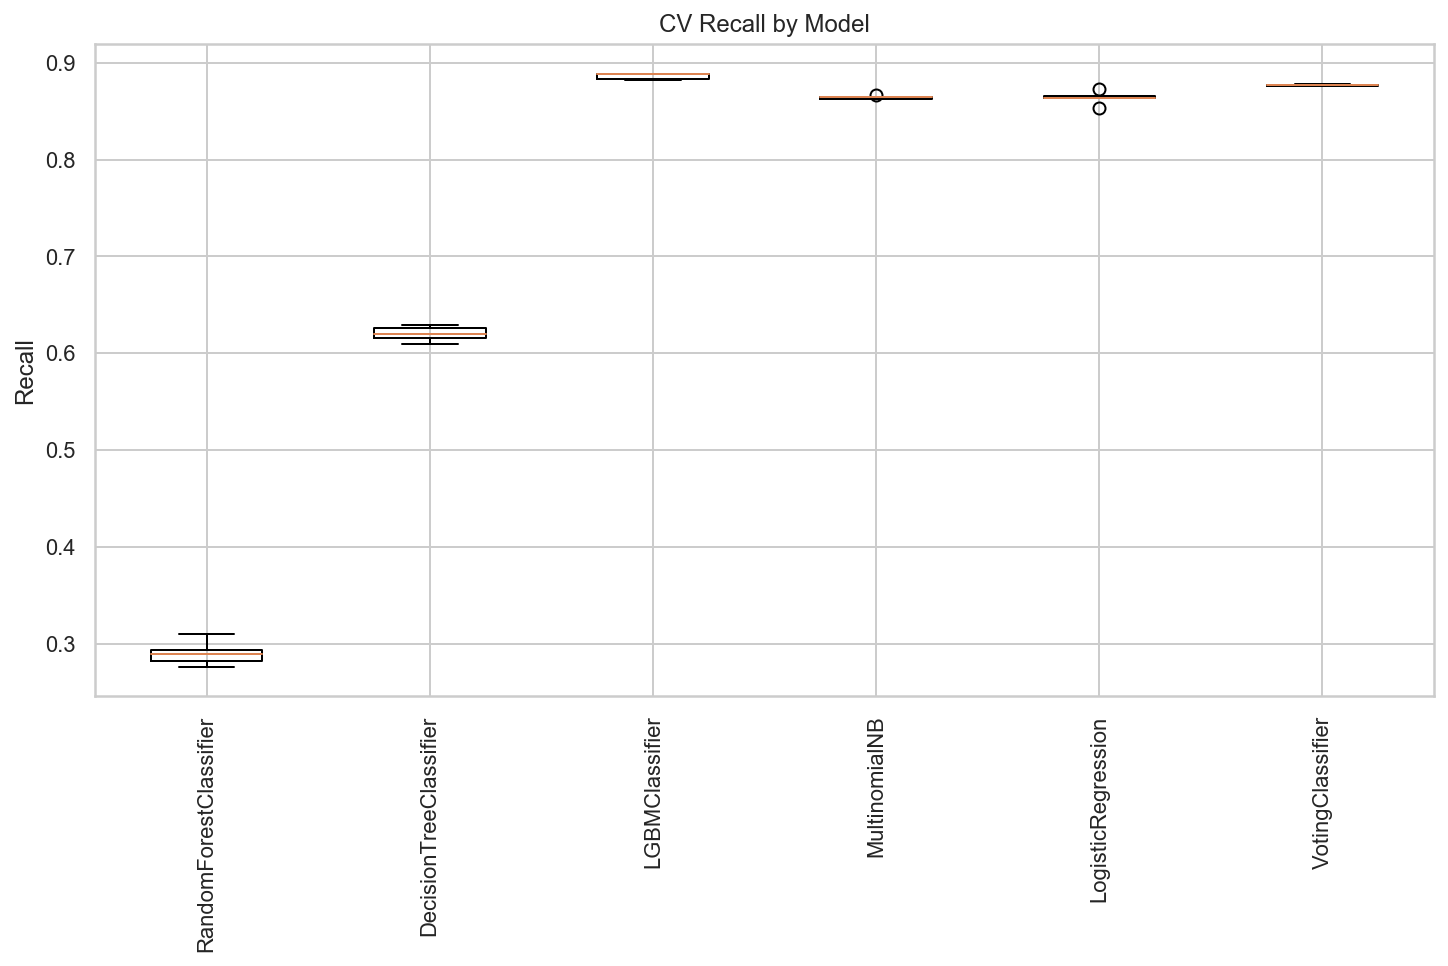

In [39]:
plt.figure(figsize=(12, 6))
plt.boxplot(rec_data)
plt.xticks(ticks=range(1, 7), labels=labels, rotation=90)
plt.title("CV Recall by Model")
plt.ylabel("Recall")
plt.show()

## 4.2 ROC Curves & AUCs

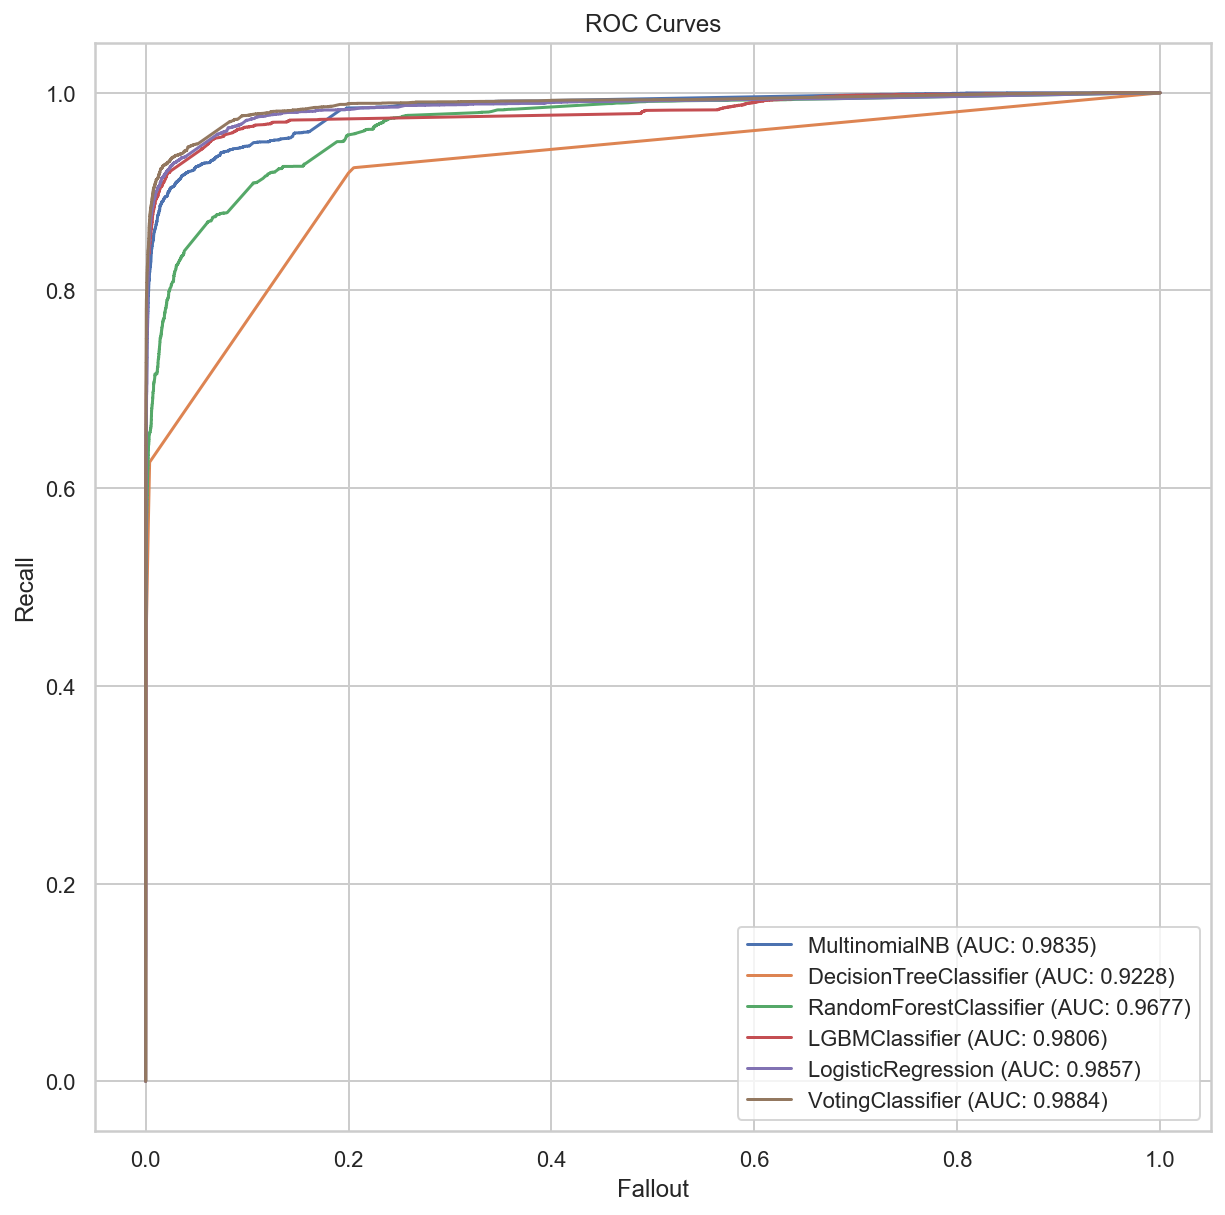

In [41]:
plt.figure(figsize=(10, 10))

for name, model in models.items():
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
    plt.plot(fpr, tpr, label="%s (AUC: %0.4f)" % (name, auc(fpr, tpr)))


plt.title("ROC Curves")
plt.xlabel('Fallout')
plt.ylabel('Recall')
plt.legend()
plt.show()

---

In [ ]:
# TODO? hyperparameter optimization

In [ ]:
# param_grid = {
#     "C": np.linspace(0.5, 1, 6)
# }

# gs = GridSearchCV(
#     estimator=LogisticRegression(),
#     param_grid=param_grid,
#     cv=5,
#     scoring="recall",
#     n_jobs=N_JOBS
# )

In [ ]:
# gs.fit(x_train, y_train)

In [ ]:
# gs.best_params_